# Goal Loop Creation

In [1]:
# Imports 
import tensorflow_datasets as tfds
import tensorflow as tf
from dlimp import DLataset
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import numpy as np
import cv2

/home/lydia/jaxrl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 17:08:51.251470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 17:08:51.251494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 17:08:51.252427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 17:08:51.257391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is op

In [2]:
# Load goal trajectory directly from TFDS 
dataset_name = "phonebooth_bend:0.0.1" ## EDIT
dataset_dir = "/home/lydia/data/goal_loops/raw" ## EDIT 
dataset_builder = tfds.builder(dataset_name, data_dir=dataset_dir)

goal_dataset = (
    DLataset.from_rlds(dataset_builder)
    .filter(lambda traj: traj["_len"][0] >= 30)
)

goal_data_iter = goal_dataset.iterator()
goal_loop = next(goal_data_iter)

# Will only need positions, orientations, and images
num_points =  goal_loop["observation"]["position"].shape[0]
positions = goal_loop["observation"]["position"]
orientations = goal_loop["observation"]["orientation"]
images = goal_loop["observation"]["image"]
images = np.array([tf.io.decode_image(i, expand_animations=False) for i in images])

2024-08-14 17:08:53.030350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 17:08:53.064550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 17:08:53.064709: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[0, 33, 66, 99, 132, 165, 198]


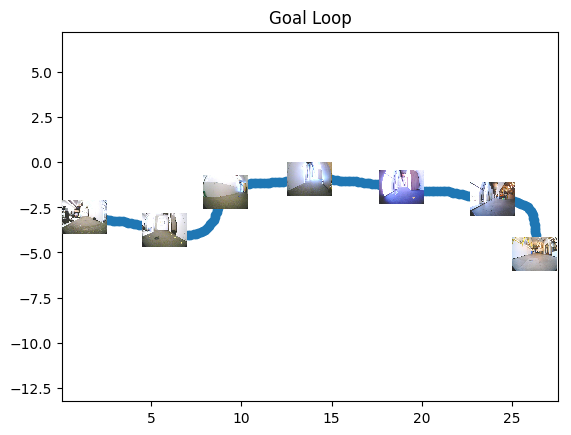

In [3]:
# Visualize goal loop, and adjust as necessary. 
# Can even identify points of interest directly, manually specifying spaced_points
num_steps = 6
spaced_points = [i * num_points// num_steps for i in range(num_steps + 1)]
spaced_points[-1] -= 1
print(spaced_points)

fig, ax = plt.subplots() # figsize = (10, 5)
plt.scatter(positions[:, 0], positions[:, 1])

for i in spaced_points:
    x, y = positions[i, 0], positions[i, 1]
    plt.scatter(x, y, s = 200, color = "orange")
    
    imagebox = OffsetImage(images[i], zoom = 0.05) # adjust zoom based on image resolution
    ab = AnnotationBbox(imagebox, (x, y), frameon = False)
    ax.add_artist(ab)

plt.title("Goal Loop")
plt.axis("equal")
plt.show()

In [4]:
# once happy, save to npz!
import cv2

img_size = 64
save_data = {}
save_data["data/position"] = [positions[i] for i in spaced_points]
save_data["data/orientation"] = [orientations[i] for i in spaced_points]
save_data["data/image"] = [images[i] for i in spaced_points]
save_data["data/image"] = [cv2.resize(np.array(img), dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC) for img in save_data["data/image"]]

# Adjust save directory as necessary 
np.savez(f'/home/lydia/data/goal_loops/npz/img_{img_size}/phonebooth_bend_6.npz', **save_data)

# Goal Assessment 

In [1]:
# Imports 
import tensorflow_datasets as tfds
import tensorflow as tf
from dlimp import DLataset
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import numpy as np
import cv2

def closest_idx(traj1, traj2):
    """ Finds closest point in traj 1 corresponding to the last point in traj2 """
    min_dist = float('inf')
    end_pos = traj2["observation"]["position"][-1]
    idx = -1

    for i in range(len(traj1["observation"]["position"])):
        d = np.linalg.norm(end_pos - traj1["observation"]["position"][i], axis=-1)
        if d < min_dist:
            idx = i
            min_dist = d

    return idx

def farthest_along(traj1, traj2, threshold):
    """ Finds farthest point along traj 1 contained in traj 2 within threshold distance """
    idx = -1

    for i in range(len(traj1["observation"]["position"])):
        traj1_pos = traj1["observation"]["position"][i]

        if (np.linalg.norm((traj2["observation"]["position"] - traj1_pos), axis=-1) < threshold).any():
            idx = i

    return idx 

def distance_travelled(traj, idx_start, idx_end):
    total_dist = 0
    for i in range(idx_start, idx_end - 1):
        total_dist += np.linalg.norm(traj["observation"]["position"]
                                     [i+1][:2] - traj["observation"]["position"][i][:2])
    return total_dist

/home/lydia/jaxrl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 17:09:27.233966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 17:09:27.233995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 17:09:27.234902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 17:09:27.240154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is op

In [2]:
# Load goal loop directly from TFDS
dataset_name = "phonebooth_bend:0.0.1" ## EDIT
dataset_dir = "/home/lydia/data/goal_loops/raw" ## EDIT 
dataset_builder = tfds.builder(dataset_name, data_dir=dataset_dir)

goal_dataset = (
    DLataset.from_rlds(dataset_builder)
    .filter(lambda traj: traj["_len"][0] >= 30)
)

goal_data_iter = iter(goal_dataset)
goal_loop = next(goal_data_iter)

# only need positions to plot
goal_positions = goal_loop["observation"]["position"]

2024-08-14 17:09:28.997390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 17:09:29.030677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 17:09:29.030837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Load deployed loop directly from TFDS
dataset_name = "phonebooth_bend_6:0.0.1" ## EDIT
dataset_dir = "/home/lydia/data/deployment/liren/" ## EDIT 
dataset_builder = tfds.builder(dataset_name, data_dir= dataset_dir)  

dep_dataset = (
    DLataset.from_rlds(dataset_builder)
)

# get to the LAST trajectory collected to assess final performance 
dep_data_iter = iter(dep_dataset)
for dep_path in dep_data_iter:
    continue

# only need positions to plot
dep_positions = dep_path["observation"]["position"]

2024-08-14 17:09:29.737454: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


furthest at 132
got 19.01 out of 28.94
completed 65.7 percent


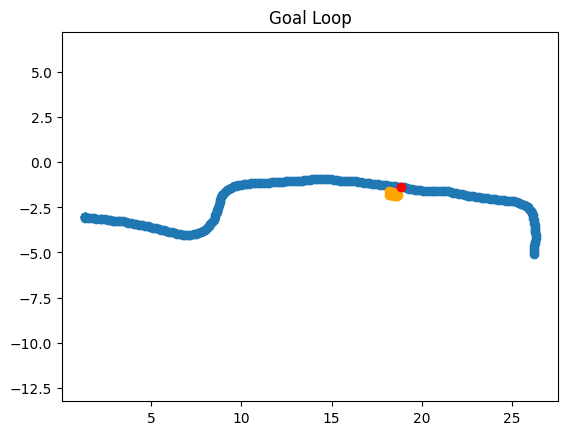

In [4]:
# View Results
reached_idx = max(closest_idx(goal_loop, dep_path), farthest_along(goal_loop, dep_path, 0.5))

plt.scatter(goal_positions[:, 0], goal_positions[:, 1])
plt.scatter(dep_positions[:, 0], dep_positions[:, 1], color = "orange")
plt.scatter(goal_positions[reached_idx, 0], goal_positions[reached_idx, 1], color = "red")

print(f"furthest at {reached_idx}")
print(f"got {distance_travelled(goal_loop, 0, reached_idx):.2f} out of {distance_travelled(goal_loop, 0, len(goal_positions) - 1):.2f}")
print(f"completed {distance_travelled(goal_loop, 0, reached_idx) / distance_travelled(goal_loop, 0, len(goal_positions) - 1) * 100:.1f} percent")

plt.title("Goal Loop")
plt.axis("equal")
plt.show()

# Docking Dictionary Creation

In [2]:
# Load paths directly from TFDS. 
# Could compile from multiple sources, if necessary. 
dataset_builder = tfds.builder("bair_loop:0.0.1", data_dir="/home/lydia/data/goal_loops/raw") # loads most recent version   

goal_dataset = (
    DLataset.from_rlds(dataset_builder)
    .filter(lambda traj: traj["_len"][0] >= 30)
)

goal_data_iter = iter(goal_dataset)
goal_loop = next(goal_data_iter)

# only need positions, orientations, and images
num_points =  goal_loop["observation"]["position"].shape[0]
positions = goal_loop["observation"]["position"]
orientations = goal_loop["observation"]["orientation"]
images = goal_loop["observation"]["image"]
images = np.array([tf.io.decode_image(i, expand_animations=False) for i in images])

2024-07-24 12:30:49.910666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 12:30:49.945564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 12:30:49.945724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[0, 26, 52, 78, 104, 130, 156, 182, 208, 234, 260, 286, 312, 338, 364, 390, 416, 442, 468, 494, 520, 546, 572, 598, 624, 650, 676, 702, 728, 754, 780, 806, 832, 858, 885, 911, 937, 963, 989, 1015, 1041, 1067, 1093, 1119, 1145, 1171, 1197, 1223, 1249, 1275, 1301, 1327, 1353, 1379, 1405, 1431, 1457, 1483, 1509, 1535, 1561, 1587, 1613, 1639, 1665, 1691, 1717, 1744, 1770, 1796, 1822, 1848, 1874, 1900, 1926, 1952, 1978, 2004, 2030, 2056, 2082, 2108, 2134, 2160, 2186, 2212, 2238, 2264, 2290, 2316, 2342, 2368, 2394, 2420, 2446, 2472, 2498, 2524, 2550, 2576, 2602]


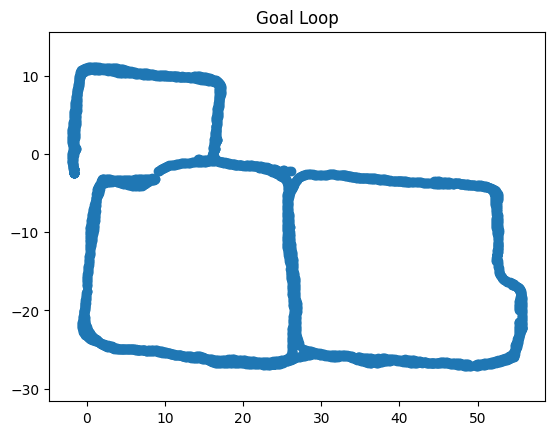

In [30]:
# Visualize Goal Loop
num_steps = 100
spaced_points = [i * num_points// num_steps for i in range(num_steps + 1)]
spaced_points[-1] -= 1
print(spaced_points)

fig, ax = plt.subplots() # figsize = (10, 5)
plt.scatter(positions[:, 0], positions[:, 1])
plt.title("Goal Loop")
plt.axis("equal")
plt.show()

In [4]:
# once happy, save!
def quaternion_to_rotation_matrix(q):
    """Convert a quaternion into a rotation matrix."""
    x, y, z, w = q
    return np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
    ])

def quaternion_to_direction_vector(q):
    """Convert a quaternion into a direction vector."""
    rot_matrix = quaternion_to_rotation_matrix(q)
    reference_vector = np.array([1, 0, 0])
    return rot_matrix.dot(reference_vector)

def pose_distance(
    start_pose: np.ndarray, # pose, quaternion 
    goal_pose: np.ndarray, # pose, quaternion 
    orientation_weight: float = 1.0,
):
    position = np.array(start_pose[:3])
    quaternion = np.array(start_pose[3:])
    goal_position = np.array(goal_pose[:3])
    goal_quaternion = np.array(goal_pose[3:])

    # Compute quaternion distance
    # q1 = quaternion / np.linalg.norm(quaternion, axis=-1, keepdims=True)
    # q2 = goal_quaternion / np.linalg.norm(goal_quaternion, axis=-1, keepdims=True)
    # d_quat = 2 * np.arccos(np.abs(np.sum(q1 * q2, axis=-1)))
    d_quat = 0
    # Compute position distance
    d_pos = np.linalg.norm(position - goal_position, axis=-1)
    return d_pos + orientation_weight * d_quat

2024-07-24 12:31:33.608916: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


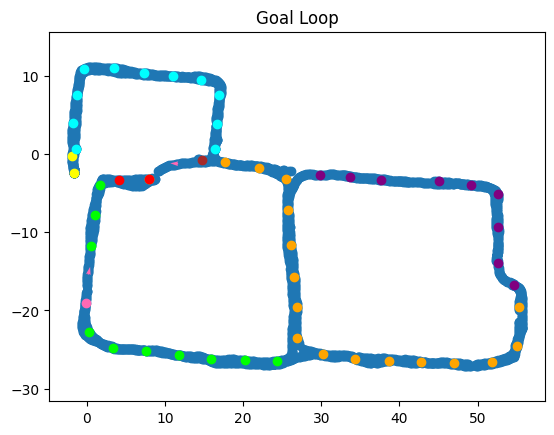

In [5]:
positions_100 = np.array([positions[i] for i in spaced_points])
orientations_100 = np.array([orientations[i] for i in spaced_points])

# visualize goal loop, adjust as necessary
fig, ax = plt.subplots() # figsize = (10, 5)
plt.scatter(positions[:, 0], positions[:, 1])

# very beginning 
start = 0
plt.scatter(positions_100[start:start+2, 0], positions_100[start:start+2, 1], color = "yellow") 

# back through kitchen to phone booth hallway
start = 21
plt.scatter(positions_100[start:start+17, 0], positions_100[start:start+17, 1], color = "orange") 
plt.scatter(positions[953, 0], positions[953, 1], color = "brown")

quaternion = orientations[954] # (0.0, 0.0, 0.7071, 0.7071)  # 90 degree rotation around z-axis
start_x = (positions[953, 0] + positions[958, 0]) / 2
start_y = (positions[953, 1] + positions[958, 1]) / 2 + 0.75
direction = quaternion_to_direction_vector(quaternion)
ax.quiver(start_x, start_y, direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color = "hotpink")


# little bit by kyle's desk
start = 37
plt.scatter(positions_100[start:start+2, 0], positions_100[start:start+2, 1], color = "red") # back through kitchen to phone booth hallway

# back to kitchen area
start = 61
plt.scatter(positions_100[start:start+9, 0], positions_100[start:start+9, 1], color = "purple") # back through kitchen to phone booth hallway

# from kitchen ish by CHAI to kyle's desk. need to fill in that one middle missing one
start = 76
plt.scatter(positions_100[start:start+10, 0], positions_100[start:start+10, 1], color = "lime") # back through kitchen to phone booth hallway
plt.scatter(positions[2158, 0], positions[2158, 1], color = "hotpink")

quaternion = orientations[2158] # (0.0, 0.0, 0.7071, 0.7071)  # 90 degree rotation around z-axis
start_x = (positions[2158, 0] + positions[2160, 0]) / 2
start_y = (positions[2158, 1] + positions[2160, 1]) / 2
direction = quaternion_to_direction_vector(quaternion)
ax.quiver(start_x, start_y, direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color = "hotpink")

# plt.scatter(positions[])
# past Goldberg's robot corner 
start = 89
plt.scatter(positions_100[start:start+11, 0], positions_100[start:start+11, 1], color = "aqua") # back through kitchen to phone booth hallway

plt.title("Goal Loop")
plt.axis("equal")
plt.show()

In [27]:
# BUILD DICTIONARY TO FOLLOW 
path_to_charge = {}

positions = np.array(positions)
orientations = np.array(orientations)

for i in range(0, 1):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos

end_position = [-1.0198686e+00, -4.6450314e-01,  3.1389201e-05]
end_orientation = [ 9.768129e-05, -4.015399e-05, -6.353835e-02,  9.979794e-01]
path_to_charge[tuple(list(positions_100[1]) + list(orientations_100[1]))] = tuple(end_position + end_orientation)
path_to_charge[tuple(end_position + end_orientation)] = "DONE"


for i in range(21, 36):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos

path_to_charge[tuple(list(positions_100[36]) + list(orientations_100[36]))] = tuple(list(positions[953]) + list(orientations[953]))
start_x = (positions[953, 0] + positions[958, 0]) / 2
start_y = (positions[953, 1] + positions[958, 1]) / 2 + 0.75
start_z = positions[953, 2]
quaternion = orientations[954]
path_to_charge[tuple(list(positions[953]) + list(orientations[953]))] = tuple([start_x, start_y, start_z] + list(quaternion))
path_to_charge[tuple([start_x, start_y, start_z] + list(quaternion))] = tuple(list(positions_100[37]) + list(orientations_100[37]))

for i in range(37, 38):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos

path_to_charge[tuple(list(positions_100[38]) + list(orientations_100[38]))] = tuple(list(positions_100[85]) + list(orientations_100[38]))
path_to_charge[tuple(list(positions_100[85]) + list(orientations_100[38]))] = tuple(list(positions_100[0]) + list(orientations_100[0]))

for i in range(61, 69):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos
    
path_to_charge[tuple(list(positions_100[69]) + list(orientations_100[69]))] = tuple(list(positions_100[34]) + list(orientations_100[34]))

for i in range(76, 82):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos

path_to_charge[tuple(list(positions_100[82]) + list(orientations_100[82]))] = tuple(list(positions[2158]) + list(orientations[2158]))
start_x = (positions[2158, 0] + positions[2160, 0]) / 2
start_y = (positions[2158, 1] + positions[2160, 1]) / 2
start_z = positions[2158, 2]
quaternion = orientations[2158]
path_to_charge[tuple(list(positions[2158]) + list(orientations[2158]))] = tuple([start_x, start_y, start_z] + list(quaternion))
path_to_charge[tuple([start_x, start_y, start_z] + list(quaternion))] = tuple(list(positions_100[83]) + list(orientations_100[83]))

for i in range(83, 84):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos

path_to_charge[tuple(list(positions_100[84]) + list(orientations_100[84]))] = tuple(list(positions_100[85]) + list(orientations_100[38]))

for i in range(89, 99):
    start_pos = tuple(list(positions_100[i]) + list(orientations_100[i]))
    end_pos = tuple(list(positions_100[i+1]) + list(orientations_100[i+1]))
    path_to_charge[start_pos] = end_pos

path_to_charge[tuple(list(positions_100[99]) + list(orientations_100[99]))] = tuple(end_position + end_orientation)

closest point (15.9439, -26.273869, 0.00057939556, 0.000970961, -0.00042157923, 0.998608, 0.052734334)


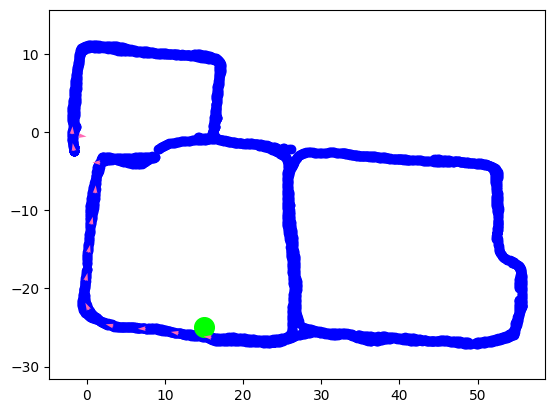

In [28]:
# testing the dictionary 
fig, ax = plt.subplots() # figsize = (10, 5)
plt.scatter(positions[:, 0], positions[:, 1], color = "blue")

point = (15, -25, 0, 0, 0, 0, 0)
plt.scatter(point[0], point[1], color = "lime", s = 200)
point = min(path_to_charge.keys(), key = lambda x: pose_distance(point, x, 0))
print("closest point", point)
while point != "DONE":
    quaternion = point[3:] # (0.0, 0.0, 0.7071, 0.7071)  # 90 degree rotation around z-axis
    start_x = point[0]
    start_y = point[1]
    direction = quaternion_to_direction_vector(quaternion)
    ax.quiver(start_x, start_y, direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color = "hotpink")
    
    point = path_to_charge[point]
plt.axis("equal")
plt.show()

In [29]:
# once happy, save!

import pickle

# converting from numpy.float32 to just plain ole float 
saving_floats = {}
for key, value in path_to_charge.items():
    float_key = tuple([float(i) for i in key])
    if value == "DONE":
        float_value = "DONE"
    else: 
        float_value = tuple([float(i) for i in value])
    saving_floats[float_key] = float_value
    
save_path = '/home/lydia/data/goal_loops/docking/rail_docking.pkl'
with open(save_path, 'wb') as handle:
    pickle.dump(saving_floats, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(save_path, 'rb') as handle:
    b = pickle.load(handle)

print(list(b.keys())[:2])

[(-1.626300573348999, -2.4165632724761963, -5.92060757753643e-07, 0.0015933879185467958, -0.0012675198959186673, 0.7624309062957764, 0.6470664143562317), (-1.8854954242706299, -0.27503255009651184, 0.00016431137919425964, -0.002416131552308798, 0.00041115711792372167, 0.681020975112915, 0.7322598099708557)]


# Video Creation

In [3]:
# Imports
import os 
import cv2  
from PIL import Image  
import tensorflow_datasets as tfds
import tensorflow as tf
from dlimp import DLataset
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Load Dataset 
# dataset_name = "chai_corner:0.0.1" ## EDIT
# dataset_dir = "/home/lydia/data/goal_loops/raw" ## EDIT 

dataset_name = "run_2_gs:0.0.1" ## EDIT
# dataset_dir = "/home/lydia/data/create_data/finetuning"
dataset_dir = "/home/lydia/data/create_data/finetuning/gc_cql_twist_dense_alpha1.0_proprioTrue_hist1_2024_07_19_22_33_54/"

dataset_builder = tfds.builder(dataset_name, data_dir=dataset_dir)

dataset = (
    DLataset.from_rlds(dataset_builder, shuffle = False, num_parallel_reads = 1)
    .filter(lambda traj: traj["_len"][0] >= 5)
)

data_iter = dataset.iterator()

2024-08-16 10:43:03.603006: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [26]:
# OPTIONALLY, (good for big datasets), find starting trajectory:
x_min, x_max = 50, 58
y_min, y_max = -20, 0

for i, traj in enumerate(data_iter):
    truthy = np.logical_and(
                    traj["observation"]["position"][:, 0] > x_min, 
                    np.logical_and(traj["observation"]["position"][:, 0] < x_max, 
                                np.logical_and(traj["observation"]["position"][:, 1] > y_min, 
                                    traj["observation"]["position"][:, 1] < y_max))
    )
    if truthy.sum() > 50:
        print(f"Consider traj {i}  as a starting point, {truthy.sum()} in zone")

print(f"Had {i} trajectories total")

Consider traj 18  as a starting point, 63 in zone
Consider traj 20  as a starting point, 100 in zone
Consider traj 24  as a starting point, 102 in zone
Consider traj 27  as a starting point, 112 in zone
Consider traj 44  as a starting point, 55 in zone
Consider traj 48  as a starting point, 165 in zone
Consider traj 51  as a starting point, 290 in zone
Consider traj 98  as a starting point, 78 in zone
Consider traj 101  as a starting point, 102 in zone
Consider traj 103  as a starting point, 197 in zone
Consider traj 104  as a starting point, 170 in zone
Consider traj 105  as a starting point, 188 in zone
Consider traj 114  as a starting point, 165 in zone
Consider traj 115  as a starting point, 203 in zone
Consider traj 116  as a starting point, 207 in zone
Consider traj 117  as a starting point, 222 in zone
Consider traj 140  as a starting point, 289 in zone
Consider traj 141  as a starting point, 127 in zone
Consider traj 147  as a starting point, 235 in zone
Consider traj 153  as a

In [31]:
# Make Video 
video_name = 'night_i_hope.mp4'  # .mp4 format
height, width = 480, 640

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
video = cv2.VideoWriter(video_name, fourcc, 120, (width, height))  

# ALL trajectories
for i, traj in enumerate(data_iter):
    # optionally only save a subset 
    # if i > 163 and i < 210:
        # Only need images
        images = traj["observation"]["image"]
        images = np.array([tf.io.decode_image(i, expand_animations=False) for i in images])

        for image in images[::2]:  
            # Expects in it BGR
            video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  

cv2.destroyAllWindows()  
video.release()